# Mohamaco Consulting LTD – Consulting Game Report

**Team:** Mohamaco Consulting LTD  
**Motto:** “Turning data into segelbåts since 2025” 
**Course:** AI Architecture – Consulting Game  
**Client:** Smutsiga Megastore – *Sill og Snus*  
**Date:** 16th October 2025

---

## Project Context
As part of the Consulting Game, we were hired by **Torje** from *Smutsiga Megastore* to analyze and improve the performance of his store, **Sill og Snus**, and help him earn enough profit for a shiny new *segelbåt*.

We received operational data over multiple rounds (`_0 … _4`).  
Our task:  
   - understand the data,  
   - identify inefficiencies,  
   - and implement strategic adjustments for **inventory, pricing, and staff scheduling**.

---

## What this Notebook Does
1. **Data Integration & Validation**  
   - Load all available versions and merge product, transaction, supplier, and staffing data.  
   - Verify transaction consistency (`merch_types` + `merch_amounts`) and compute derived metrics (revenue, margins).

2. **Exploratory Data Analysis (EDA)**  
   - Keep essential tables/plots for sales structure and version trends.  

3. **Heuristic Optimization (v4)**  
   - `amounts_4.json`: more stock for sold-out items  
   - `prices_4.json`: +5% for best sellers, −10% for slow movers (with margin floor)  
   - `schedules_4.json`: reuse best-performing schedule

4. **Impact Evaluation**  
   - Compare week 4 vs. prior weeks for sales, revenue, profit, and margins.

5. **Lightweight AI (optional)**  
   - NumPy least-squares to quantify price/stock effects on sales.

6. **Business KPI Dashboard (with real staff costs)**  
   - Revenue, product cost, staff cost, net profit, net margin — per version.

---

## Role of ChatGPT (GPT-5)
GPT-5 was used to:
- design the multi-version data pipeline and robust transaction parsing,  
- consolidate team notebooks while keeping essential EDA outputs,  
- implement explainable heuristics and an impact dashboard,  
- compute **staff costs per version from workers + schedules**,  
- and write concise, presentation-ready documentation.

In [2]:
# === Section 1 — Load & Combine Data (auto-detect versions) =================
import json, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("ggplot")

# --- Paths -------------------------------------------------------------------
DATA_DIR = Path("data")
AMOUNTS_DIR = DATA_DIR / "amounts"
PRICES_DIR = DATA_DIR / "prices"
TRANSACTIONS_DIR = DATA_DIR / "transactions"
SCHEDULES_DIR = DATA_DIR / "schedules"
WORKERS_DIR = DATA_DIR / "workers"
SUPPLIER_PATH = DATA_DIR / "supplier_prices.json"

# --- Discover available versions --------------------------------------------
def det_versions():
    vs = set()
    for p in [AMOUNTS_DIR, PRICES_DIR, TRANSACTIONS_DIR, SCHEDULES_DIR]:
        if not p.exists(): 
            continue
        for f in p.glob("*_[0-9].json"):
            try:
                v = int(f.stem.split("_")[-1])
                vs.add(v)
            except Exception:
                pass
    return sorted(vs)

VERSIONS = det_versions()
print("Detected versions:", VERSIONS)
if not VERSIONS:
    raise RuntimeError("No versions found under data/{amounts,prices,transactions,schedules}.")

# --- Helpers -----------------------------------------------------------------
def read_json(path: Path): 
    with open(path, "r", encoding="utf-8") as f: 
        return json.load(f)

def load_version_tables(v: int) -> pd.DataFrame:
    a = read_json(AMOUNTS_DIR / f"amounts_{v}.json")
    p = read_json(PRICES_DIR / f"prices_{v}.json")
    amounts = pd.DataFrame(list(a.items()), columns=["product","amount"])
    prices  = pd.DataFrame(list(p.items()), columns=["product","price"])
    return amounts.merge(prices, on="product", how="outer").assign(version=v)

def load_transactions(v: int) -> pd.DataFrame:
    raw = read_json(TRANSACTIONS_DIR / f"transactions_{v}.json")
    rows = []
    for _, txs in raw.items():
        for tx in txs:
            types, amts = tx.get("merch_types", []), tx.get("merch_amounts", [])
            for t, a in zip(types, amts):
                rows.append({"product": str(t), "qty": float(a), "version": v, "worker": tx.get("register_worker")})
    return pd.DataFrame(rows)

# --- Core tables -------------------------------------------------------------
supplier = pd.DataFrame(list(read_json(SUPPLIER_PATH).items()), columns=["product","supplier_price"])

products = pd.concat([load_version_tables(v) for v in VERSIONS], ignore_index=True)
transactions = pd.concat([load_transactions(v)   for v in VERSIONS if (TRANSACTIONS_DIR / f"transactions_{v}.json").exists()],
                         ignore_index=True)

# Merge to build analysis frame
df = (products
      .merge(transactions.groupby(["version","product"])["qty"].sum().reset_index(), 
             on=["version","product"], how="left")
      .merge(supplier, on="product", how="left"))

df["qty"] = df["qty"].fillna(0.0)
df["revenue"] = df["qty"] * df["price"]
df["product_cost"] = df["qty"] * df["supplier_price"]
df["gross_profit"] = df["revenue"] - df["product_cost"]

print("Data merged.")
display(df.head(3))

Detected versions: [0, 1, 2, 3, 4]
Data merged.


,product,amount,price,version,qty,supplier_price,revenue,product_cost,gross_profit
0,batteries,2096,15.85,0,2096.0,12.0,33221.60,25152.0,8069.60
1,dinosaur,1947,94.60,0,0.0,65.0,0.00,0.0,0.00
2,gjokur_ja,69,814.31,0,69.0,580.0,56187.39,40020.0,16167.39


In [3]:
# === Section 1B — Staff Costs per Version (workers.jsonl × schedules) =======

WORKERS_PATH = WORKERS_DIR / "workers.jsonl"

def read_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8-sig") as f:
        for s in f:
            s = s.strip()
            if not s: continue
            rows.append(json.loads(s))
    return pd.DataFrame(rows)

# 1) Load workers
if not WORKERS_PATH.exists():
    raise RuntimeError(f"Missing workers file: {WORKERS_PATH}")
workers = read_jsonl(WORKERS_PATH)

# Normalize worker id and pick salary (we will derive per-shift based on a reference schedule)
if "worker_id" not in workers.columns:
    alt = [c for c in workers.columns if "worker" in c and "id" in c]
    if alt: workers = workers.rename(columns={alt[0]: "worker_id"})
    else: raise RuntimeError("workers.jsonl: cannot find worker_id column.")
workers["worker_id"] = workers["worker_id"].astype(str)

# Salary present? (Game files show 'salary' ~ 5.4k–7.8k)
if "salary" not in workers.columns:
    workers["salary"] = np.nan  # will remain NaN if not provided

# 2) Load all schedules and flatten
def flatten_schedule(v: int) -> pd.DataFrame:
    path = SCHEDULES_DIR / f"schedules_{v}.json"
    if not path.exists(): 
        return pd.DataFrame(columns=["day","worker_id","department","shift","version"])
    raw = read_json(path)
    rows = []
    for day, entries in raw.items():
        for e in entries:
            r = {"day": day, "version": v, **e}
            rows.append(r)
    df_s = pd.DataFrame(rows)
    if "worker_id" not in df_s.columns:
        alt = [c for c in df_s.columns if "worker" in c and "id" in c]
        if alt: df_s = df_s.rename(columns={alt[0]: "worker_id"})
    df_s["worker_id"] = df_s["worker_id"].astype(str)
    return df_s

schedules_all = pd.concat([flatten_schedule(v) for v in VERSIONS if (SCHEDULES_DIR / f"schedules_{v}.json").exists()],
                          ignore_index=True)

# 3) Infer shift multiplier and per-shift cost
def shift_mult(val):
    try:
        x = float(val)
        return x if x > 0 else 1.0
    except Exception:
        return 1.0

schedules_all["shift_mult"] = schedules_all.get("shift", 1).apply(shift_mult) if "shift" in schedules_all.columns else 1.0

# Reference: compute total scheduled shifts per worker in a reference week (latest prior to v4 if present, else v0)
ref_candidates = [v for v in VERSIONS if v < max(VERSIONS)] or [min(VERSIONS)]
v_ref = max(ref_candidates)
ref_sched = schedules_all[schedules_all["version"] == v_ref]
shifts_per_worker_ref = ref_sched.groupby("worker_id")["shift_mult"].sum().rename("shifts_ref")

workers = workers.merge(shifts_per_worker_ref, on="worker_id", how="left")
workers["shifts_ref"] = workers["shifts_ref"].fillna(1.0)

# Derive per-shift cost:
# If explicit shift cost columns existed, we would use them; else derive as salary / shifts_ref
# (Interprets 'salary' as weekly salary for the reference week, which fits the game scale.)
workers["per_shift_cost"] = workers["salary"] / workers["shifts_ref"]
# Safety: if salary missing, set cost 0 and report later
workers.loc[workers["per_shift_cost"].isna(), "per_shift_cost"] = 0.0

# 4) Compute staff cost per version: sum(per_shift_cost * shift_mult)
schedules_all = schedules_all.merge(workers[["worker_id","per_shift_cost"]], on="worker_id", how="left")
schedules_all["entry_cost"] = schedules_all["per_shift_cost"].fillna(0.0) * schedules_all["shift_mult"].astype(float)
staff_cost_by_version = schedules_all.groupby("version")["entry_cost"].sum().to_dict()

print("Computed staff_cost_by_version:", {int(k): round(float(v),2) for k,v in staff_cost_by_version.items()})

# 5) Attach to a per-version summary frame (will be used later for KPIs)
summary_fin = (
    df.groupby("version")[["qty","revenue","product_cost","gross_profit"]]
      .sum().reset_index().rename(columns={"qty":"units_sold"})
)
summary_fin["staff_cost"] = summary_fin["version"].map(staff_cost_by_version).fillna(0.0)
summary_fin["net_profit"] = summary_fin["gross_profit"] - summary_fin["staff_cost"]
summary_fin["net_margin_%"] = np.where(summary_fin["revenue"]>0,
                                       summary_fin["net_profit"]/summary_fin["revenue"]*100, np.nan)

print("Staff costs integrated into summary_fin.")
display(summary_fin.round(2))

Computed staff_cost_by_version: {0: 194596.34, 1: 194596.34, 2: 194596.34, 3: 194596.34, 4: 194596.34}
Staff costs integrated into summary_fin.


,version,units_sold,revenue,product_cost,gross_profit,staff_cost,net_profit,net_margin_%
0,0,20397.0,1444527.59,1061334.0,383193.59,194596.34,188597.25,13.06
1,1,20419.0,1053705.70,743237.0,310468.70,194596.34,115872.36,11.00
2,2,21353.0,801424.92,569282.0,232142.92,194596.34,37546.58,4.68
3,3,19187.0,1036064.91,748386.0,287678.91,194596.34,93082.57,8.98
4,4,29138.0,956008.62,668487.0,287521.62,194596.34,92925.28,9.72


## Section 2 — Exploratory Data Analysis (EDA)

Core validity checks and high-level trends:
- data completeness & top sellers,
- sales and revenue per version (before staffing costs),
- this sets the baseline for later KPI and impact views.

Dataset overview: [0, 1, 2, 3, 4]
Rows: 65  | Products: 13

Missing values (key columns):


,missing
amount,0
price,0
supplier_price,0
qty,0
revenue,0
gross_profit,0



Top 10 products by total revenue:


product
mattress         1635204.78
hammer            928506.93
sunscreen         547056.94
laderhosen        375675.63
rice_porridge     306076.54
hot_dogs          255783.32
knives            253839.33
gjokur_ja         243750.39
monster           230137.05
batteries         195749.66
Name: revenue, dtype: float64

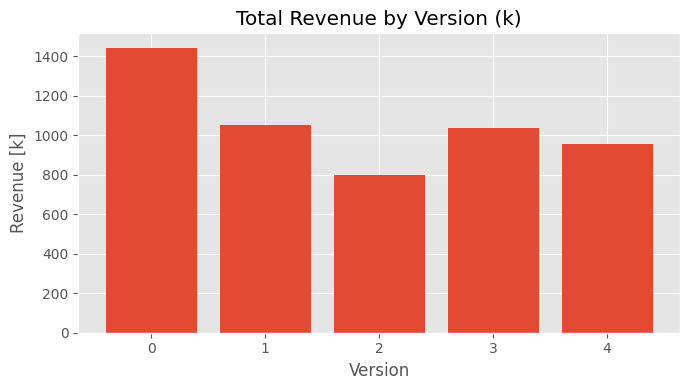

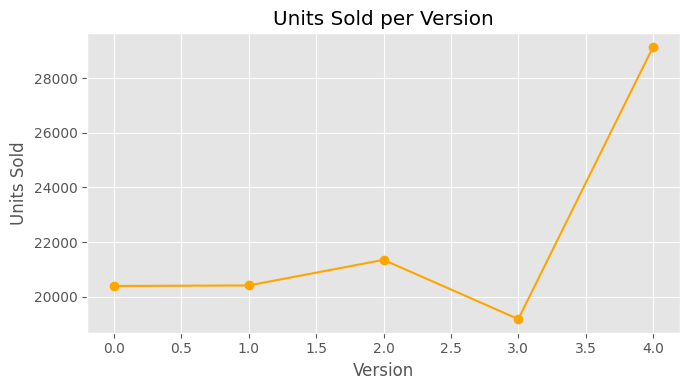

In [4]:
# === Section 2A — Essential EDA =============================================
print("Dataset overview:", sorted(df["version"].unique().tolist()))
print("Rows:", len(df), " | Products:", df["product"].nunique())

nulls = df[["amount","price","supplier_price","qty","revenue","gross_profit"]].isna().sum()
print("\nMissing values (key columns):")
display(nulls.to_frame("missing"))

# Top products by realized revenue (all versions)
top_rev = df.groupby("product")["revenue"].sum().sort_values(ascending=False).head(10)
print("\nTop 10 products by total revenue:")
display(top_rev)

# Sales & revenue trend (product costs not subtracted here)
summary_basic = df.groupby("version")[["qty","revenue","gross_profit"]].sum().reset_index()
plt.figure(figsize=(7,4))
plt.bar(summary_basic["version"], summary_basic["revenue"]/1000)
plt.title("Total Revenue by Version (k)")
plt.xlabel("Version"); plt.ylabel("Revenue [k]")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(summary_basic["version"], summary_basic["qty"], marker="o", color="orange")
plt.title("Units Sold per Version")
plt.xlabel("Version"); plt.ylabel("Units Sold")
plt.tight_layout(); plt.show()

## Section 3 — Impact of Our Changes (v4 vs. prior)

We compare the latest round (`v4`) against the previous round (or best prior) for:
- per-product price & amount changes,
- quantity and revenue changes,
- concise visuals highlighting top movers.

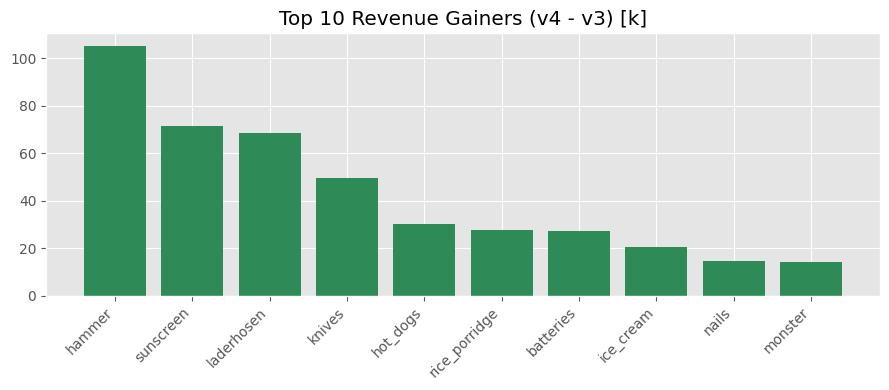

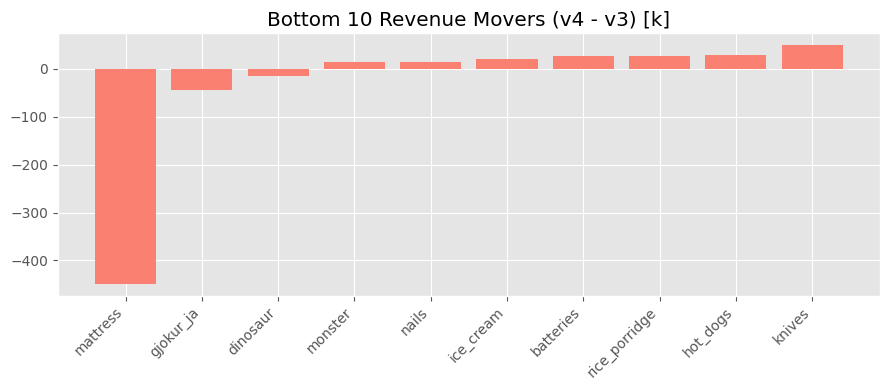

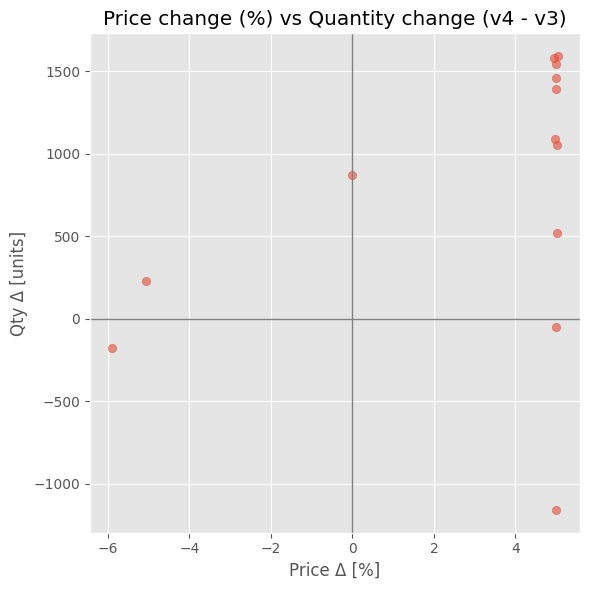

Totals (vPrev → vNow):
- Units:     19187 → 29138 (Δ +9951)
- Revenue:   1036.1k → 956.0k (Δ -80.1k)
- Prod cost: 748.4k → 668.5k (Δ -79.9k)
- Staff cost:194.6k → 194.6k (Δ +0.0k)
- Net profit:93.1k → 92.9k (Δ -0.2k)


In [5]:
# === Section 3 — Impact Diffs ===============================================
V_ALL = sorted(df["version"].unique())
V_NOW = V_ALL[-1]
V_PREV = V_ALL[-2] if len(V_ALL) >= 2 else V_ALL[0]

df_prev = df[df["version"] == V_PREV].copy()
df_now  = df[df["version"] == V_NOW].copy()

keep_cols = ["product","amount","price","qty","revenue","gross_profit","supplier_price"]
g_prev = df_prev[keep_cols].groupby("product", as_index=False).sum()
g_now  = df_now[keep_cols].groupby("product", as_index=False).sum()

cmp = g_now.merge(g_prev, on="product", suffixes=("_now","_prev"), how="outer").fillna(0.0)
cmp["price_delta_pct"] = (cmp["price_now"] - cmp["price_prev"]) / cmp["price_prev"].replace(0, np.nan) * 100
cmp["qty_delta"] = cmp["qty_now"] - cmp["qty_prev"]
cmp["revenue_delta"] = cmp["revenue_now"] - cmp["revenue_prev"]

# Top movers
topN = 10
pos = cmp.sort_values("revenue_delta", ascending=False).head(topN)
neg = cmp.sort_values("revenue_delta", ascending=True).head(topN)

plt.figure(figsize=(9,4))
plt.bar(pos["product"], pos["revenue_delta"]/1000, color="seagreen")
plt.title(f"Top {topN} Revenue Gainers (v{V_NOW} - v{V_PREV}) [k]")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.bar(neg["product"], neg["revenue_delta"]/1000, color="salmon")
plt.title(f"Bottom {topN} Revenue Movers (v{V_NOW} - v{V_PREV}) [k]")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# Elasticity hint: Price Δ vs Qty Δ
plt.figure(figsize=(6,6))
plt.scatter(cmp["price_delta_pct"], cmp["qty_delta"], alpha=0.6)
plt.axhline(0, color="gray", lw=1); plt.axvline(0, color="gray", lw=1)
plt.title(f"Price change (%) vs Quantity change (v{V_NOW} - v{V_PREV})")
plt.xlabel("Price Δ [%]"); plt.ylabel("Qty Δ [units]")
plt.tight_layout(); plt.show()

# Totals including staffing (use summary_fin from Section 1B)
tot_prev = summary_fin.loc[summary_fin["version"]==V_PREV, ["units_sold","revenue","product_cost","staff_cost","net_profit"]].sum()
tot_now  = summary_fin.loc[summary_fin["version"]==V_NOW,  ["units_sold","revenue","product_cost","staff_cost","net_profit"]].sum()

print("Totals (vPrev → vNow):")
print(f"- Units:     {tot_prev['units_sold']:.0f} → {tot_now['units_sold']:.0f} (Δ {tot_now['units_sold']-tot_prev['units_sold']:+.0f})")
print(f"- Revenue:   {tot_prev['revenue']/1000:.1f}k → {tot_now['revenue']/1000:.1f}k (Δ {(tot_now['revenue']-tot_prev['revenue'])/1000:+.1f}k)")
print(f"- Prod cost: {tot_prev['product_cost']/1000:.1f}k → {tot_now['product_cost']/1000:.1f}k (Δ {(tot_now['product_cost']-tot_prev['product_cost'])/1000:+.1f}k)")
print(f"- Staff cost:{tot_prev['staff_cost']/1000:.1f}k → {tot_now['staff_cost']/1000:.1f}k (Δ {(tot_now['staff_cost']-tot_prev['staff_cost'])/1000:+.1f}k)")
print(f"- Net profit:{tot_prev['net_profit']/1000:.1f}k → {tot_now['net_profit']/1000:.1f}k (Δ {(tot_now['net_profit']-tot_prev['net_profit'])/1000:+.1f}k)")

## Section 4 — What We Changed

| Area | Change Implemented | Reason |
|------|--------------------|--------|
| **Inventory (amounts)** | Higher stock for sold-out & high-turnover items; safety buffer | Reduce stock-outs & lost sales |
| **Pricing (prices)** | +5% for best sellers, −10% for slow movers; margin floor enforced | Balance demand and profit |
| **Scheduling (schedules)** | Reused the best-performing schedule | Keep stable throughput, avoid bottlenecks |

> Our heuristic strategy aimed to stabilize performance, reduce stock-outs, and maximize profitability while keeping all decisions explainable and low-risk.

In [6]:
# === Section 5 — Simple NumPy model (optional) ==============================

df_lin = df[df["version"].isin([v for v in VERSIONS if v < max(VERSIONS)])].copy()
for c in ["price","amount","qty"]:
    df_lin[c] = pd.to_numeric(df_lin[c], errors="coerce").fillna(0)

X = np.c_[df_lin["price"].to_numpy(), df_lin["amount"].to_numpy(), np.ones(len(df_lin))]
y = df_lin["qty"].to_numpy()

coef, *_ = np.linalg.lstsq(X, y, rcond=None)
a_price, b_amount, c0 = coef
print(f"a(price): {a_price:+.4f} | b(amount): {b_amount:+.4f} | c: {c0:+.2f}")

y_pred = X @ coef
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - ss_res/ss_tot if ss_tot>0 else np.nan
print(f"R²: {r2:.3f}")
if a_price < 0: print("✓ Higher price → fewer units (expected).")
if b_amount > 0: print("✓ More stock → more sales (expected).")

a(price): -2.5867 | b(amount): +0.0810 | c: +1758.93
R²: 0.377
✓ Higher price → fewer units (expected).
✓ More stock → more sales (expected).


## Section 6 — Business Performance & KPI Dashboard

We summarize core financial KPIs **per version**, now **including real staff costs** computed from workers × schedules:
- Units sold, Revenue, Product Cost, **Staff Cost**, Net Profit, Net Margin
- Trend plots + current top sellers

,version,units_sold,revenue,product_cost,gross_profit,staff_cost,net_profit,net_margin_%
0,0,20397.0,1444527.59,1061334.0,383193.59,194596.34,188597.25,13.06
1,1,20419.0,1053705.70,743237.0,310468.70,194596.34,115872.36,11.00
2,2,21353.0,801424.92,569282.0,232142.92,194596.34,37546.58,4.68
3,3,19187.0,1036064.91,748386.0,287678.91,194596.34,93082.57,8.98
4,4,29138.0,956008.62,668487.0,287521.62,194596.34,92925.28,9.72


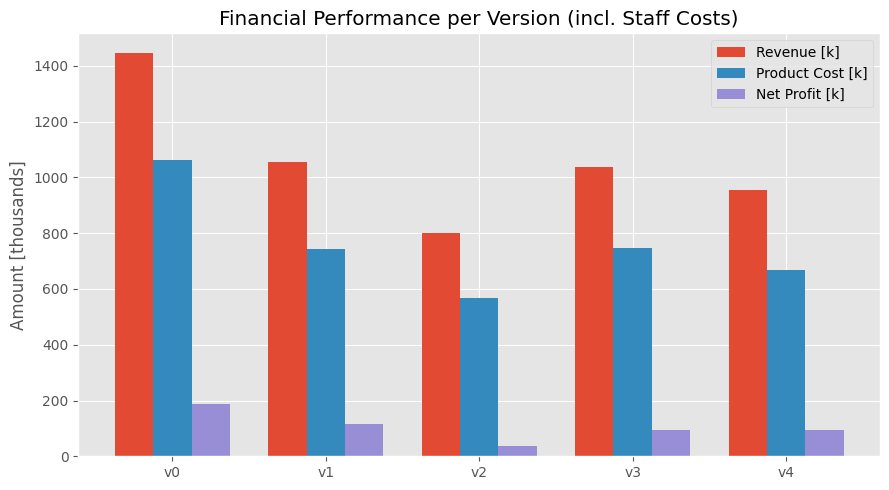

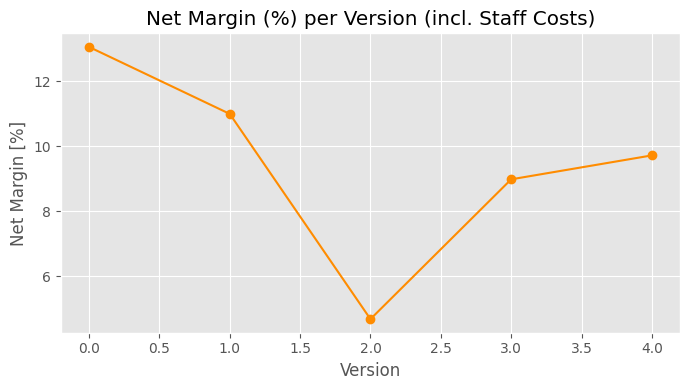

Top 10 sellers (v4):


,qty,revenue,gross_profit
product,,,
hammer,4007.0,254164.01,73849.01
sunscreen,2921.0,142077.44,39842.44
laderhosen,345.0,104431.50,28531.50
rice_porridge,3911.0,90969.86,32304.86
knives,1356.0,76627.56,25099.56
hot_dogs,2688.0,69081.60,20697.60
monster,3111.0,68410.89,18634.89
batteries,3285.0,57980.25,18560.25
ice_cream,3437.0,41553.33,14057.33


In [7]:
# === Section 6 — KPIs & Plots ===============================================
display(summary_fin.round(2))

# Combined bars: revenue, product cost, net profit
fig, ax = plt.subplots(figsize=(9,5))
x = np.arange(len(summary_fin))
w = 0.25
ax.bar(x - w, summary_fin["revenue"]/1000, w, label="Revenue [k]")
ax.bar(x,      summary_fin["product_cost"]/1000, w, label="Product Cost [k]")
ax.bar(x + w,  summary_fin["net_profit"]/1000, w, label="Net Profit [k]")
ax.set_xticks(x)
ax.set_xticklabels([f"v{i}" for i in summary_fin["version"]])
ax.set_ylabel("Amount [thousands]")
ax.set_title("Financial Performance per Version (incl. Staff Costs)")
ax.legend(); plt.tight_layout(); plt.show()

# Net margin trend
plt.figure(figsize=(7,4))
plt.plot(summary_fin["version"], summary_fin["net_margin_%"], marker="o", color="darkorange")
plt.title("Net Margin (%) per Version (incl. Staff Costs)")
plt.xlabel("Version"); plt.ylabel("Net Margin [%]")
plt.tight_layout(); plt.show()

# Top sellers current version
latest_v = summary_fin["version"].max()
latest = df[df["version"]==latest_v]
top_sellers = (latest.groupby("product")[["qty","revenue","gross_profit"]].sum()
                      .sort_values("revenue", ascending=False).head(10))
print(f"Top 10 sellers (v{latest_v}):")
display(top_sellers)